# Computational and Algorithmic Quantification of Neurofeedback Learning


In order to get access to external files run the following cell and connect your Google Drive to this notebook (accept all permissions)


In [186]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


The workshop folder should now be accessible at:  */content/drive/MyDrive/NFworkshop*

In [187]:
# list contents of workshop folder
workdir = '/content/drive/MyDrive/NFworkshop' 
!ls /content/drive/MyDrive/NFworkshop

 database_msq_ratings_reg_success.xlsx
'NF Learning Workshop - MSQ.ipynb'
'NF Learning Workshop - Q-Learning.ipynb'
 requirements.txt


Run the following cell to make sure we have all the packages needed for the workshop installed.

In [188]:
! pip install -r '/content/drive/MyDrive/NFworkshop/requirements.txt'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [189]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import math

# Section 1 - Descriptive statistics of the mental space subjects use during NF practice 
First, Let's load a sample dataset of the Mental Strategies Questionnaire for Neurofeedback (MSQ-NF) and have a look at the data. 

In [190]:
data = pd.read_excel(workdir+'/database_msq_ratings_reg_success.xlsx');
data.head()

,Study,sub_num,Neural_Target,session_num,cycle_num,Cohens_D,Qhat,Vision_Exteroception,Auditory_Exteroception,Smell_Exteroception,...,Frustration,Tension,Other_Emotion,Pleasure,Suffering,Approach,Avoidance,Expectation,Impulse,Other_Motivation
0,1.0,11.0,1.0,1.0,6.0,-0.079342,0.382500,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1.0,11.0,1.0,1.0,7.0,-1.888084,0.140000,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,11.0,1.0,1.0,8.0,0.051572,0.417500,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,11.0,1.0,2.0,6.0,0.242841,0.465000,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,11.0,1.0,2.0,7.0,0.151268,0.473333,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In each msq feature column, there is either **0** - which indicates a 'No' answer, **1** - which indicates 'Yes', or **NaN** - which 
indicates that the rater did not have enough information to conclude whether or not this feature was present in the strategy. 
Hence, for some features which were harder to interpret for the raters, the data is sparse (i.e. a lot of NaN values).

*Importantly, sparsity is a characteristic of the current dataset (stemming from 3rd person ratings). When the subjects themselves fill the MSQ following each training session, the data is much less sparse (rarely containing NaN values).

---


## Let's plot regulation success:
***Q-hat*** (Q̂) is a non-parametric effect size, which is the outcome measure we use to quantify regulation *PER TRIAL*, in order to deal with extreme values uniformely.
- Below 0.5 - target (efp amygdala/mesolimbic) down regulation (i.e regulate < rest) 
- Above 0.5 - target (efp amygdala/mesolimbic) up regulation (i.e regulate > rest)


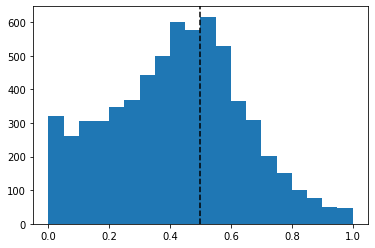

In [191]:
fig=plt.hist(data['Qhat'], bins = 20)
fig=plt.axvline(0.5,linestyle='--',color='black')

***Cohen's D*** is a parametric effect size, used here for visulatization purposes.

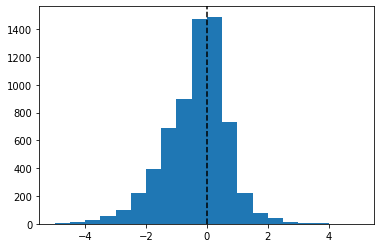

In [192]:
fig=plt.hist(data['Cohens_D'], bins = 20, range=(-5,5)) 
fig=plt.axvline(0,linestyle='--',color='black')

We can see that the whole dataset is skewed towards downregulation (Q-hat < 0.5, Cohen's D < 0), which makes sense as two thirds of the data is taken from amygdala down-regulation training 

### We want to examine the frequency of mental features. This can be interesting from various reasons:
- Do certain groups (e.g. target vs. control groups, patients vs. healthy subjects etc.) use different features?
- Do successful regulation trials are characterized by a mental space that differs from that of unsuccessful regulation trials?
- Does the mental space change along practice (i.e. trials at the end compared to the beginning of training)?

#### Let's look at option 1 - comparing two different training groups, one practicing amygdala efp downregulation (N=4100), and the other reward mesolimbic upregulation (N=2400). 



In [194]:
# The MSQ is divided into three meta-categories, which we will plot seperately 
content_features = ['Vision_Exteroception', 'Auditory_Exteroception', 'Smell_Exteroception',
           'Taste_Exteroception', 'Tactile_Exteroception', 'Pulse', 'Viceral_sensations',
           'Breathing', 'Muscle_sensation', 'Vision_Imagery', 'Auditory_Imagery', 
           'Smell_Imagery', 'Taste_Imagery', 'Tactile_Imagery', 'Memory_or_Imaginative',
           'Motor_Imagery', 'Lingual', 'Conceptual_Arithmetic','Intercation_with_other_people']
psychological_dimensions_features = ['Arousal', 'Valence']
manner_features = [ 'Rhythmic', 'Interface_Engaged_Detached', 'Involving_one_or_many_strategies']

# organize data for plotting frequencies of msq_features use:
def organize_data_for_plotting(df, features:list):
    #create df of specific meta category
    #important to add neural target column to seperate groups 
    meta_category = df[features]
    meta_category = meta_category.join(df['Neural_Target'])
    
    #split data by neural target
    amyg = meta_category[meta_category['Neural_Target'] ==1]
    mesolimbic = meta_category[(meta_category['Neural_Target'] ==3) | (meta_category['Neural_Target'] ==4)]
    
    #create value count for each neural target
    def create_value_count(df, neural_target:str):

        df_count = df.apply(pd.Series.value_counts)
        df_count = df_count.transpose()
        df_count.reset_index(inplace = True)
        df_count.rename(columns = {'index': 'Feature', 0: 'No', 1:'Yes'}, inplace= True)
        df_count['total_count'] = len(df)
        df_count['yes_proportion'] = df_count['Yes'] / df_count['total_count']
        df_count['no_proportion'] = df_count['No'] / df_count['total_count']
        df_count['Neural_Target'] = neural_target
        df_count = df_count.drop(df_count[df_count['Feature'] == 'Neural_Target'].index)
        
        return df_count
    
    amyg_count = create_value_count(amyg, 'AmygEFP downregulation')
    mesolimbic_count = create_value_count(mesolimbic, 'Mesolimbic upregulation')
    
    #concat value count df's
    total_count = pd.concat([amyg_count, mesolimbic_count], ignore_index = True)
    total_count.drop(columns = [3,4], inplace= True)
    
    if ('Valence' in features) or ('Arousal' in features):
        #change data structure for changing feature label
        total_count = total_count.melt(id_vars= ['Feature', 'Neural_Target', 'total_count'], value_vars = ['Yes', 'No'], value_name= 'count')
        
        #change feature label 
        for i in range(len(total_count)):
            if (total_count.loc[i, 'Feature'] == 'Arousal') and (total_count.loc[i, 'variable'] == 'Yes'):
                total_count.loc[i, 'Feature'] = 'Low Arousal'
            if (total_count.loc[i, 'Feature'] == 'Arousal') and (total_count.loc[i, 'variable'] == 'No'):
                total_count.loc[i, 'Feature'] = 'High Arousal'
            if (total_count.loc[i, 'Feature'] == 'Valence') and (total_count.loc[i, 'variable'] == 'Yes'):
                total_count.loc[i, 'Feature'] = 'Negative Valence'
            if (total_count.loc[i, 'Feature'] == 'Valence') and (total_count.loc[i, 'variable'] == 'No'):
                total_count.loc[i, 'Feature'] = 'Positive Valence'
        
        #add proportion column
        total_count['yes_proportion'] = total_count['count'] / total_count['total_count']
        #change column order
        total_count = total_count[['Feature', 'count', 'total_count', 'yes_proportion', 'Neural_Target']]
        #sort by neural target column
        total_count = total_count.sort_values(by=['Neural_Target'])
        total_count = total_count.reset_index(drop = True)


    return total_count

content_count = organize_data_for_plotting(data, content_features)
psychological_dimensions_count = organize_data_for_plotting(data, psychological_dimensions_features)
manner_features_count = organize_data_for_plotting(data, manner_features)

In [201]:
def create_spyder_plot(df, features_for_plot, title):
    
    df_amygdala = df[df['Neural_Target'] == 'AmygEFP downregulation']
    df_mesolimbic = df[df['Neural_Target'] == 'Mesolimbic upregulation']
    df_amygdala  = df_amygdala[df_amygdala['Feature'].isin(features_for_plot)].reset_index(drop = True) 
    df_mesolimbic = df_mesolimbic[df_mesolimbic['Feature'].isin(features_for_plot)].reset_index(drop = True) 

    # ------- PART 1: Create background
     
    # number of variable
    categories = list(df_amygdala['Feature'])
    N = len(categories)
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    # Initialise the spider plot
    ax = plt.subplot(111, polar=True)
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    # Draw one ax per variable + add labels
    plt.xticks(angles[:-1], categories)
    # Draw ylabels
    y_ticks = [i/100 for i in range(0, 110, 10)]
    ax.set_rlabel_position(0)
    plt.yticks(y_ticks, [str(x) for x in y_ticks], color="black", size=7)
    plt.ylim(0,1)
    
    # ------- PART 2: Add plots
              
    # Ind1
    values= df_amygdala['yes_proportion'].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color = 'purple', linewidth=1, linestyle='solid', label="Amygdala downregulation")
    ax.fill(angles, values, 'b', alpha=0.1)
     
    # Ind2
    values= df_mesolimbic['yes_proportion'].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color = 'coral', linewidth=1, linestyle='solid', label="Mesolimbic upregulation")
    ax.fill(angles, values, 'b', alpha=0.1)
     
    # Add legend
    plt.legend(loc='lower left', prop={'size': 10}, bbox_to_anchor=(-0.25,-0.25), borderaxespad=0)
    
    #Add title
    plt.title(title,pad=15)
    
    # Show the graph    
    plt.show()

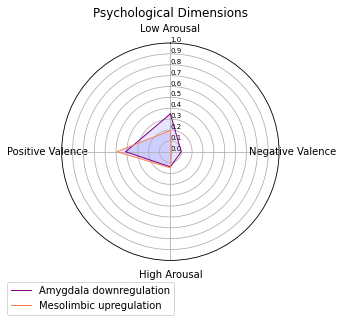

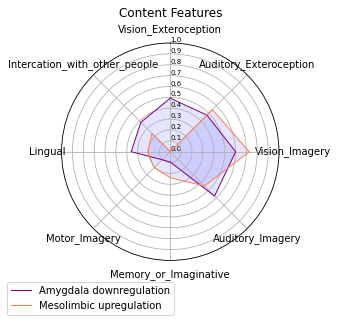

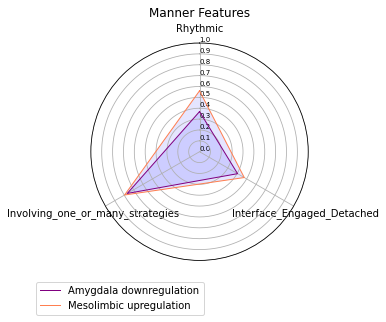

In [202]:
# As some content features and extremely rare (approximately all 'Nan' or 'No'), no need to plot them. Choose which feature to plot according to data
content_subset = ['Vision_Imagery', 'Auditory_Imagery', 'Tactile_Imagery'
          'Breathing','Lingual','Memory_or_Imaginative', 'Motor_Imagery',
          'Vision_Exteroception','Auditory_Exteroception',
          'Intercation_with_other_people']

create_spyder_plot(psychological_dimensions_count,['High Arousal', 'Positive Valence', 'Low Arousal', 'Negative Valence'], 'Psychological Dimensions')
create_spyder_plot(content_count, content_subset,'Content Features')
create_spyder_plot(manner_features_count, list(manner_features_count['Feature'].unique()),'Manner Features')

Inspecting the frequency of the features, we can see a phenomenological difference between the mental spaces of both groups on some features (e.g. content features of vision exteroception, interaction with other people, and positive vs negative valence in the psychological dimensions)

#  Section 2 - Dimensionality reduction of the mental space - SVD analysis

The MSQ defines a rich and inclusive phenomenological space with multiple mental features of various categories. However, as done in other fields when quantifying high-dimensional spaces, we might want to find out whether these features are consistently clustered together in intelligable ways that we may not anticipate. Revealing the structure of clustering can provide a more compact, data-driven description of the mental space subjects actually explore (as opposed to our theoretical assumptions regarding types of mental meta-categories such as perception/imagery etc.), and therefore allowing us to better characterize its interaction with regulation success.

To acheive this, we will use an established dimensionality reduction method, termed "Singular Value Decomposition" (SVD) analysis. This method will detect statistical patterns (such as covariances between specific MSQ features), and will result in a small number of general mental dimensions, or SVD components, accounting for clusters of MSQ features associations.


---


In order to run SVD on this dataset we first need to extract only the features values for a subset of amygdala down-regulation. We will also replace NaN values with 0.5 as these represent ambiguous feature values.   
 

In [160]:
from scipy.linalg import svd
from statsmodels.multivariate.factor_rotation import rotate_factors

svd_data = data.loc[data['Neural_Target']==1]
svd_data = svd_data.iloc[:,7:]
txt = svd_data.columns
txt = txt.str.replace('_',' ') # fix txt for plotting
svd_data = svd_data.fillna(0.5) # replace NaN with 0.5

It is a common practice to center the data
(i.e., decrease the entries in matrix columns by column means)
before conducting SVD to improve the interpretability of the SVD
dimensions. This is because the first SVD dimension extracted
from noncentered data is strongly correlated with the frequencies
of the objects in rows and columns. As the remaining dimensions
have to be orthogonal to the first one, the resulting SVD dimensions may not represent the data well

In [161]:
ct_svd_data = svd_data.apply(lambda x: x-x.mean()).to_numpy()

In [168]:
# Run SVD first on centered data
U, S, V = svd(ct_svd_data, lapack_driver='gesvd')

We need to select how many components to keep from the analysis, one way is to use the 'elbow criterion' - We plot the percent variance explained by each feature and observe where additional features add very little information.  

Text(0.5, 1.0, 'Centered data - %variance exp.')

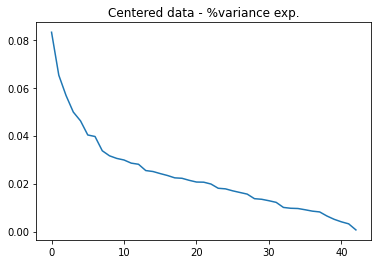

In [169]:
percS=S/np.sum(S)

plt.plot(percS)
plt.title("Centered data - %variance exp.")
#fig.savefig('variance_explained_py.jpg')

Now we need to decide how many components to use. Generally, we use an 'elbow' criterion, which states that when the graphs become linear, adding components does not contribute substantially to the overall explained variance of the data. 

In [170]:
# Choose number of components
numComponents=4 
ct_numComponents=4 

V_small=V.T[:,:numComponents]  # The output of the SVD algorithm gives V transposed

Text(0.5, 0, 'Components')

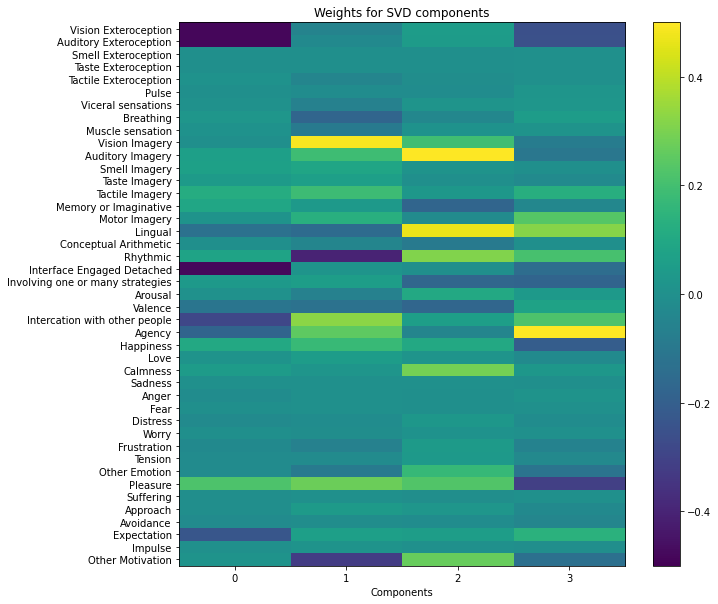

In [208]:
#Plot Weights for Selected Components
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(V_small,aspect='auto',vmin=-0.5,vmax=0.5)
ax.set_title("Weights for SVD components")
plt.colorbar(im)
ax.set_yticklabels(txt)
ax.set_yticks(np.arange(len(txt)))
ax.set_xticks(np.arange(numComponents))
ax.set_xticklabels(np.arange(numComponents))
ax.set_xlabel('Components')

Each component is composed of all the MSQ features with different weights. Features given weights in the same direction are more likely to be included (or not included) in the represented mental space.

Next, let get scores for each subject. These can later be use in modeling.

In [227]:
SVD_score = np.dot(ct_svd_data,V_small); # this step takes us from feature space to svd component space
pred = np.dot(SVD_score,V_small.T) # and back to feature space using only the selected components

correlations = np.zeros((ct_svd_data.shape[1]))
for col in np.arange(ct_svd_data.shape[1]):
    correlations[col] = np.corrcoef(ct_svd_data[:,col],pred[:,col])[1,0] 

np.mean(correlations)

0.42133392391832825

We can see that now, each strategy is categorized along 4 components that compactly represent the whole MSQ space.

Now let's understand what is the link between the MSQ space and the SVD components. To do so, we can inspect a strategy that recieved high negative and positive values for a specific component, and compare it with its original MSQ categories 

In [246]:
print(SVD_score[np.argmax((SVD_score[:,1]))])
svd_data.iloc[np.argmax((SVD_score[:,1])),:]

[ 0.88853788  1.56247634 -0.19367509  0.50127319]


Vision_Exteroception                0.0
Auditory_Exteroception              0.0
Smell_Exteroception                 0.0
Taste_Exteroception                 0.0
Tactile_Exteroception               0.0
Pulse                               0.0
Viceral_sensations                  0.0
Breathing                           0.0
Muscle_sensation                    0.0
Vision_Imagery                      1.0
Auditory_Imagery                    0.5
Smell_Imagery                       0.5
Taste_Imagery                       1.0
Tactile_Imagery                     0.5
Memory_or_Imaginative               1.0
Motor_Imagery                       1.0
Lingual                             0.0
Conceptual_Arithmetic               0.0
Rhythmic                            0.0
Interface_Engaged_Detached          0.0
Involving_one_or_many_strategies    0.0
Arousal                             0.5
Valence                             0.0
Intercation_with_other_people       1.0
Agency                              1.0


For this strategy, the SVD score of component 1 is positive and high. We expect a correspondence between component weigths and the MSG categories. For example, 'Vision Imagery' has a large positive weight and is **present** in the strategy. Likewise, 'Rythmic' has a large negative weight and is **not present** in the strategy.

In [245]:
print(SVD_score[np.argmax(np.abs(SVD_score[:,1]))])
svd_data.iloc[np.argmax(np.abs(SVD_score[:,1])),:]

[-0.14349913 -1.81023041  0.02450781 -0.44136838]


Vision_Exteroception                1.0
Auditory_Exteroception              1.0
Smell_Exteroception                 0.0
Taste_Exteroception                 0.0
Tactile_Exteroception               1.0
Pulse                               0.0
Viceral_sensations                  0.0
Breathing                           1.0
Muscle_sensation                    1.0
Vision_Imagery                      0.0
Auditory_Imagery                    0.0
Smell_Imagery                       0.0
Taste_Imagery                       0.0
Tactile_Imagery                     0.0
Memory_or_Imaginative               0.0
Motor_Imagery                       0.0
Lingual                             0.0
Conceptual_Arithmetic               0.0
Rhythmic                            1.0
Interface_Engaged_Detached          0.0
Involving_one_or_many_strategies    1.0
Arousal                             1.0
Valence                             1.0
Intercation_with_other_people       0.0
Agency                              0.0


Here, when the SVD score for component 1 is very low, we expect that each strong weight in this component will be anti-correlated with the MSQ categories (large positive weights will indicate '0', and large negative weights will indicate '1'. Check if that's actually the case.

# Section 3 - Interactions between mental features and regulation success - Mixed Linear Effects (MLE) regression analyses

To keep things simple, we will look only on the amygdala downregulation subset (N=4114 trials). We will test the difference in regulation success between instances of Yes's and No's, ignoring NaN values, for each feature seperately.

Sparsity of a certain feature does not need to worry us - since the statistical test intrinsically penalizes small sample sizes - which will need a larger effect size to pass significance threshold. However, the proportion between 'Yes's and 'No's may be too unbalanced (e.g. 99% yes and 1% no) to representative of the population, but nevertheless produce significant results. There is no clear-cut criterion here. Roughly considering the size of our dataset and its sparsity, we chose to perform tests only on features that have at least 10% of both categories. This is adressed below in the code.

We use mixed linear models to account for the nested hierarchical structure of the data (multiple time points per session, per subject), and to allow for missing time points (which is not enabled in standard repeated measures ANOVA)
the model: 

regulation success ~ 1 + msq_feature + (1|sub/ses) + ϵ.

The independent variable of regulation success - Qhat; the explanatory variable - msq feature (fixed effect), and two nested random effects we want to control for (subject/session). 

In lmer R the syntax would simply be: Qhat ~ msq_feature + (1|sub/ses). Here we are using Python's statsmodels, which implements our model as follows: 


In [247]:
import statsmodels.formula.api as smf

df = data[data['Neural_Target']==1]

mlem_stats = pd.DataFrame()
for msq_ftr in df.columns[7:]:
    cur_test_data = df[["sub_num","session_num","cycle_num","Qhat",msq_ftr]]
    cur_test_data.dropna(inplace=True) # drop 'Nan's
    
    # calculate yes/all data (yes+no) ratio 
    if cur_test_data[msq_ftr].isin([1]).any():
        yes_no_ratio = cur_test_data[msq_ftr].value_counts()[1]/len(cur_test_data)
    else:
        yes_no_ratio = 0
    if yes_no_ratio > 0.1 and yes_no_ratio <0.9: # check if the ratio is between 0.1 and 0.9
        md = smf.mixedlm(f"Qhat ~ {msq_ftr}", data = cur_test_data, re_formula="1", vc_formula={"session_num": "0 + C(session_num)","cycle_num": "0 + C(cycle_num*session_num)"},groups="sub_num")
        mdf = md.fit()
        print(mdf.summary())
        mlem_stats = pd.concat([mlem_stats,mdf.summary().tables[1].iloc[1][2:4]],axis=1) # MAYBE ADD THE Ns

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


            Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   Qhat     
No. Observations:    4001      Method:               REML     
No. Groups:          103       Scale:                0.0288   
Min. group size:     5         Log-Likelihood:       1051.1246
Max. group size:     80        Converged:            Yes      
Mean group size:     38.8                                     
--------------------------------------------------------------
                     Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept            0.345    0.011 31.350 0.000  0.324  0.367
Vision_Exteroception 0.012    0.008  1.448 0.148 -0.004  0.028
sub_num Var          0.009    0.009                           
cycle_num Var        0.001    0.005                           
session_num Var      0.004    0.004                           



/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    Qhat     
No. Observations:    3977       Method:                REML     
No. Groups:          103        Scale:                 0.0289   
Min. group size:     5          Log-Likelihood:        1041.3454
Max. group size:     80         Converged:             Yes      
Mean group size:     38.6                                       
----------------------------------------------------------------
                       Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.342    0.011 31.248 0.000  0.321  0.364
Auditory_Exteroception 0.019    0.008  2.319 0.020  0.003  0.035
sub_num Var            0.009    0.009                           
cycle_num Var          0.001    0.005                           
session_num Var        0.004    0.004                           



/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: Qhat     
No. Observations:   3836    Method:             REML     
No. Groups:         103     Scale:              0.0287   
Min. group size:    5       Log-Likelihood:     1003.3288
Max. group size:    80      Converged:          Yes      
Mean group size:    37.2                                 
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.347    0.011 30.250 0.000  0.325  0.370
Vision_Imagery  0.006    0.008  0.718 0.473 -0.010  0.022
sub_num Var     0.009    0.009                           
cycle_num Var   0.001    0.005                           
session_num Var 0.004    0.004                           



/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


          Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Qhat    
No. Observations:   3605     Method:              REML    
No. Groups:         103      Scale:               0.0295  
Min. group size:    5        Log-Likelihood:      906.4439
Max. group size:    80       Converged:           Yes     
Mean group size:    35.0                                  
----------------------------------------------------------
                 Coef. Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        0.339    0.012 28.442 0.000  0.315  0.362
Auditory_Imagery 0.025    0.010  2.558 0.011  0.006  0.044
sub_num Var      0.009    0.009                           
cycle_num Var    0.001    0.005                           
session_num Var  0.004    0.004                           



/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


          Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Qhat    
No. Observations:   3782     Method:              REML    
No. Groups:         103      Scale:               0.0291  
Min. group size:    4        Log-Likelihood:      981.1046
Max. group size:    80       Converged:           Yes     
Mean group size:    36.7                                  
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        0.356    0.010 34.626 0.000  0.335  0.376
Tactile_Imagery -0.020    0.012 -1.568 0.117 -0.044  0.005
sub_num Var      0.009    0.009                           
cycle_num Var    0.001    0.005                           
session_num Var  0.004    0.004                           



/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    Qhat    
No. Observations:     2984       Method:                REML    
No. Groups:           102        Scale:                 0.0294  
Min. group size:      1          Log-Likelihood:        774.0088
Max. group size:      80         Converged:             Yes     
Mean group size:      29.3                                      
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.354    0.011 32.720 0.000  0.333  0.376
Memory_or_Imaginative -0.015    0.013 -1.094 0.274 -0.041  0.012
sub_num Var            0.009    0.009                           
cycle_num Var          0.000    0.005                           
session_num Var        0.004    0.004                           



/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Qhat     
No. Observations:  3976     Method:              REML     
No. Groups:        103      Scale:               0.0289   
Min. group size:   8        Log-Likelihood:      1043.6421
Max. group size:   80       Converged:           Yes      
Mean group size:   38.6                                   
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        0.353    0.010 33.951 0.000  0.333  0.373
Motor_Imagery   -0.021    0.013 -1.591 0.112 -0.047  0.005
sub_num Var      0.009    0.009                           
cycle_num Var    0.001    0.004                           
session_num Var  0.004    0.004                           



/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: Qhat     
No. Observations:   3957    Method:             REML     
No. Groups:         103     Scale:              0.0289   
Min. group size:    5       Log-Likelihood:     1040.4061
Max. group size:    80      Converged:          Yes      
Mean group size:    38.4                                 
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.342    0.011 32.444 0.000  0.321  0.362
Lingual         0.028    0.008  3.657 0.000  0.013  0.044
sub_num Var     0.009    0.009                           
cycle_num Var   0.001    0.005                           
session_num Var 0.004    0.004                           



/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: Qhat     
No. Observations:   3893    Method:             REML     
No. Groups:         103     Scale:              0.0286   
Min. group size:    5       Log-Likelihood:     1033.5548
Max. group size:    80      Converged:          Yes      
Mean group size:    37.8                                 
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.348    0.011 32.651 0.000  0.327  0.369
Rhythmic        0.011    0.008  1.379 0.168 -0.005  0.027
sub_num Var     0.009    0.009                           
cycle_num Var   0.001    0.005                           
session_num Var 0.004    0.004                           



/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     Qhat     
No. Observations:      3966        Method:                 REML     
No. Groups:            103         Scale:                  0.0286   
Min. group size:       7           Log-Likelihood:         1046.5047
Max. group size:       80          Converged:              Yes      
Mean group size:       38.5                                         
--------------------------------------------------------------------
                           Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                  0.346    0.011 32.225 0.000  0.325  0.367
Interface_Engaged_Detached 0.011    0.008  1.388 0.165 -0.005  0.027
sub_num Var                0.009    0.009                           
cycle_num Var              0.001    0.005                           
session_num Var            0.004    0.004         

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


                   Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       Qhat     
No. Observations:         4089          Method:                   REML     
No. Groups:               103           Scale:                    0.0287   
Min. group size:          8             Log-Likelihood:           1086.1154
Max. group size:          80            Converged:                Yes      
Mean group size:          39.7                                             
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                         0.378    0.012 31.574 0.000  0.354  0.401
Involving_one_or_many_strategies -0.033    0.008 -4.110 0.000 -0.049 -0.017
sub_num Var                       0.009    0.009                           
cycle_num Var                  

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


          Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Qhat    
No. Observations:   2001     Method:              REML    
No. Groups:         91       Scale:               0.0281  
Min. group size:    1        Log-Likelihood:      518.6495
Max. group size:    78       Converged:           Yes     
Mean group size:    22.0                                  
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        0.401    0.015 26.889 0.000  0.372  0.431
Arousal         -0.054    0.011 -4.703 0.000 -0.076 -0.031
sub_num Var      0.008    0.012                           
cycle_num Var    0.001    0.007                           
session_num Var  0.005    0.006                           



/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Qhat    
No. Observations:  2098     Method:              REML    
No. Groups:        99       Scale:               0.0256  
Min. group size:   1        Log-Likelihood:      597.8299
Max. group size:   74       Converged:           Yes     
Mean group size:   21.2                                  
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.328    0.011 29.929 0.000  0.306  0.349
Valence         0.127    0.011 11.439 0.000  0.105  0.148
sub_num Var     0.007    0.010                           
cycle_num Var   0.002    0.007                           
session_num Var 0.005    0.006                           



/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      Qhat     
No. Observations:       3904         Method:                  REML     
No. Groups:             103          Scale:                   0.0290   
Min. group size:        5            Log-Likelihood:          1017.0808
Max. group size:        80           Converged:               Yes      
Mean group size:        37.9                                           
-----------------------------------------------------------------------
                              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.341    0.011 32.112 0.000  0.320  0.362
Intercation_with_other_people 0.022    0.007  3.103 0.002  0.008  0.037
sub_num Var                   0.009    0.009                           
cycle_num Var                 0.001    0.005                           
session_n

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Qhat    
No. Observations:  3768     Method:              REML    
No. Groups:        103      Scale:               0.0289  
Min. group size:   5        Log-Likelihood:      981.3193
Max. group size:   80       Converged:           Yes     
Mean group size:   36.6                                  
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.346    0.011 32.225 0.000  0.325  0.367
Agency          0.021    0.009  2.471 0.013  0.004  0.038
sub_num Var     0.009    0.009                           
cycle_num Var   0.001    0.005                           
session_num Var 0.005    0.004                           



/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Qhat     
No. Observations:  4099     Method:              REML     
No. Groups:        103      Scale:               0.0288   
Min. group size:   8        Log-Likelihood:      1091.9590
Max. group size:   80       Converged:           Yes      
Mean group size:   39.8                                   
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        0.358    0.010 34.697 0.000  0.337  0.378
Happiness       -0.045    0.010 -4.372 0.000 -0.065 -0.025
sub_num Var      0.009    0.009                           
cycle_num Var    0.001    0.004                           
session_num Var  0.004    0.004                           



/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Qhat     
No. Observations:  4099     Method:              REML     
No. Groups:        103      Scale:               0.0287   
Min. group size:   8        Log-Likelihood:      1090.3102
Max. group size:   80       Converged:           Yes      
Mean group size:   39.8                                   
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        0.359    0.010 35.410 0.000  0.339  0.379
Calmness        -0.033    0.008 -4.031 0.000 -0.050 -0.017
sub_num Var      0.009    0.008                           
cycle_num Var    0.001    0.004                           
session_num Var  0.004    0.004                           



/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Qhat     
No. Observations:  4093     Method:              REML     
No. Groups:        103      Scale:               0.0289   
Min. group size:   8        Log-Likelihood:      1082.6550
Max. group size:   80       Converged:           Yes      
Mean group size:   39.7                                   
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        0.354    0.010 34.588 0.000  0.334  0.374
Other_Emotion   -0.020    0.011 -1.786 0.074 -0.041  0.002
sub_num Var      0.009    0.009                           
cycle_num Var    0.001    0.004                           
session_num Var  0.004    0.004                           



/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Qhat     
No. Observations:  4099     Method:              REML     
No. Groups:        103      Scale:               0.0289   
Min. group size:   8        Log-Likelihood:      1082.4727
Max. group size:   80       Converged:           Yes      
Mean group size:   39.8                                   
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        0.354    0.010 33.919 0.000  0.333  0.374
Pleasure        -0.006    0.008 -0.737 0.461 -0.022  0.010
sub_num Var      0.009    0.009                           
cycle_num Var    0.001    0.004                           
session_num Var  0.004    0.004                           



/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


          Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: Qhat     
No. Observations:   4099    Method:             REML     
No. Groups:         103     Scale:              0.0287   
Min. group size:    8       Log-Likelihood:     1090.4087
Max. group size:    80      Converged:          Yes      
Mean group size:    39.8                                 
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.346    0.010 33.863 0.000  0.326  0.366
Expectation     0.038    0.010  4.020 0.000  0.020  0.057
sub_num Var     0.009    0.009                           
cycle_num Var   0.001    0.004                           
session_num Var 0.004    0.004                           

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Qhat     
No. Observations:   4099     M

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [250]:
mlem_stats.T

,z,P>|z|
Vision_Exteroception,1.448,0.148
Auditory_Exteroception,2.319,0.020
Vision_Imagery,0.718,0.473
Auditory_Imagery,2.558,0.011
Tactile_Imagery,-1.568,0.117
Memory_or_Imaginative,-1.094,0.274
Motor_Imagery,-1.591,0.112
Lingual,3.657,0.000
Rhythmic,1.379,0.168
Interface_Engaged_Detached,1.388,0.165


We can see various significant effects of the interaciton between regulation success and MSQ features. 

Let's plot the significant results to get a better grasp of these effets. For each significant MSQ feature, we will plot the difference between mean regulation success levels when feature was used ('Yes'group) and when it was not used ('No' group).  


In [252]:
def plot_qhat_diff(df, features_for_plot:list, title:str):
           
    #create df summary of qhat mean for each feature 
    features = list(df)[4:48]
        
    #create list of Qhat mean for yes/ no 
    qhat_yes_mean = []
    for feat in features:
        mean_yes = df[df[feat]==1]['Qhat'].mean()
        qhat_yes_mean.append(mean_yes)
        
    qhat_no_mean = []
    for feat in features:
        mean_no = df[df[feat]==0]['Qhat'].mean()
        qhat_no_mean.append(mean_no)
        
    #add lists to df
    qhat_means = pd.DataFrame([qhat_no_mean, qhat_yes_mean], columns = features)
        
    #arrange index
    no_yes = ['no', 'yes']
    qhat_means.index = no_yes
        
    qhat_means = qhat_means.transpose()
        
    #change features to columns 
    qhat_means = qhat_means.reset_index()
    qhat_means = qhat_means.rename(columns = {'index': 'feature'})
        
    #add diff column
    qhat_means['diff'] = qhat_means['yes'] - qhat_means['no']
        
    #only include features you want to plot
    df_qhat_means_for_plotting = qhat_means.loc[qhat_means['feature'].isin(features_for_plot)]
    
    #sort values 
    df_qhat_means_for_plotting.sort_values(by=['diff'],ascending = False, inplace = True)
    df_qhat_means_for_plotting.reset_index(drop = True, inplace= True)
    
    ## ploting:
    # create list of colors for plotting
    colors= []
    for i in range(len(df_qhat_means_for_plotting)):
        if df_qhat_means_for_plotting.loc[i, 'diff'] > 0:
            colors.append('salmon')
        else:
            colors.append('limegreen')
        
    #control for bar width
    def change_width(ax, new_value) :
        for patch in ax.patches :
            current_width = patch.get_width()
            diff = current_width - new_value
    
            # we change the bar width
            patch.set_width(new_value)
    
            # we recenter the bar
            patch.set_x(patch.get_x() + diff * .5)
    
    #change feature name for plot
    feature_label = {'Vision_Exteroception' : 'Sensory Vision',
                     'Auditory_Exteroception': 'Sensory Auditory',
                     'Smell_Exteroception': 'Sensory Smell',
                     'Taste_Exteroception': 'Sensory Taste',
                     'Tactile_Exteroception': 'Sensory Tactile',
                     'Viceral_sensations': 'Viceral Sensations',
                     'Muscle_sensation': 'Muscle Sensation',
                     'Vision_Imagery': 'Vision Imagery',
                     'Auditory_Imagery': 'Auditory Imagery',
                     'Smell_Imagery': 'Smell Imagery',
                     'Taste_Imagery': 'Taste Imagery',
                     'Tactile_Imagery': 'Tactile Imagery',
                     'Memory_or_Imaginative': 'Memory',
                     'Motor_Imagery': 'Motor Imagery',
                     'Lingual': 'Lingual',
                     'Conceptual_Arithmetic': 'Conceptual-Arithmetic' ,
                     'Rhythmic': 'Rhythmic',
                     'Interface_Engaged_Detached': 'Interface Engagement ',
                     'Involving_one_or_many_strategies': 'One Strategy',
                     'Arousal': 'Low Arousal',
                     'Valence': 'Negative Valence',
                     'Intercation_with_other_people': 'Social'}
    
    x_tick_feature_labels = [feature_label.get(item,item) for item in features_for_plot]
            
    #plot
    sns.set_theme(style='darkgrid')
    fig = sns.barplot(x='feature', y='diff', data=df_qhat_means_for_plotting , palette=colors)
    fig.set_xticklabels(x_tick_feature_labels)
    fig.tick_params(axis='x', rotation=90, labelsize=10) 
    fig.set(ylim=(-0.1, 0.15))
    fig.set_xlabel("",fontsize=15)
    fig.set_ylabel("Down Regulation           Up Regulation", fontsize=12)
    
    fig.set_title(title, fontsize=15)
    
    change_width(fig, .5)
    
    #plt.savefig(path, bbox_inches= 'tight', dpi = 500)
    plt.show()

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


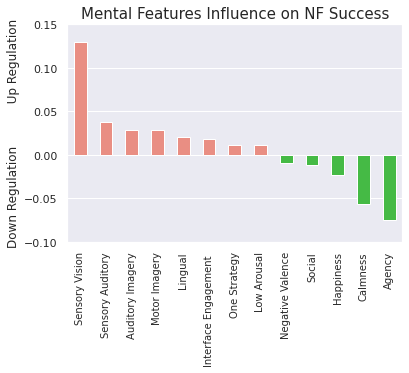

In [253]:
## the features to plot are manually defined here. Of course this could be derived automatically from the results above. 
sig_MSQ_ftr_list = ['Vision_Exteroception', 'Auditory_Exteroception',
             'Auditory_Imagery', 'Motor_Imagery', 'Lingual',
             'Interface_Engaged_Detached', 'Involving_one_or_many_strategies',
             'Arousal', 'Valence', 'Intercation_with_other_people',
             'Happiness', 'Calmness', 'Agency']

plot_qhat_diff(df, sig_MSQ_ftr_list, 'Mental Features Influence on NF Success')

Remember that in this subset subjects were trying to down-regulate their signal.
Therefore, we can see that among the significant effects, some features indicate succesful down-regulation (e.g. Agency, Calmness, Happiness etc.) while other mental features indicate an opposite effect! (e.g. Sensory vision, Sensory Auditory, Auditory imagery, etc.)
Notably, both effects are of interest, even in clinical contexts - in order to know which features are good candidates for regulation, as well as which features one should avoid.

We can also check whether the SVD components, which are a more compact description of the mental space of subjects, are linked with regulation success. Here we'll use a combined mixed linear regression model (including all SVD components in the model as fixed effects), since the SVD components are intrinsically uncorrelated (we can check this explicitly as well), hence no risk of colinearity between regressors.


In [324]:
df1=data.loc[data['Neural_Target']==1,['sub_num','session_num','cycle_num','Qhat']].reset_index()
df2=pd.DataFrame(SVD_score, columns=['svd_comp1','svd_comp2','svd_comp3','svd_comp4']).reset_index()
svd_test_data=pd.concat([df1,df2],axis=1)
svd_test_data=svd_test_data[:4000]

In [326]:
svd_test_data.dropna(inplace=True) # drop 'Nan's
md_svd = smf.mixedlm("Qhat ~ svd_comp1 + svd_comp2 + svd_comp3 + svd_comp4", data = svd_test_data, re_formula="1", vc_formula={"session_num": "0 + C(session_num)","cycle_num": "0 + C(cycle_num*session_num)"},groups="sub_num")
mdf_svd = md_svd.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [327]:
mdf_svd.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
==========================================================
Model:             MixedLM  Dependent Variable:  Qhat     
No. Observations:  3987     Method:              REML     
No. Groups:        98       Scale:               0.0290   
Min. group size:   8        Log-Likelihood:      1043.0496
Max. group size:   80       Converged:           Yes      
Mean group size:   40.7                                   
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        0.356    0.010 34.566 0.000  0.335  0.376
svd_comp1       -0.017    0.004 -3.796 0.000 -0.025 -0.008
svd_comp2       -0.006    0.006 -1.121 0.262 -0.018  0.005
svd_comp3       -0.004    0.007 -0.500 0.617 -0.018  0.010
svd_comp4        0.031    0.008  3.863 0.000  0.015  0.047
sub_num Var      0.009    0.009                           
cycle_num Var    0.000    0.004                           
session_num Var  0.004    0.004                           
==========================================================

"""

# Section 4 - Exploration dynamics of the mental space of subjects - Cosine similarity analyses

In stage 1 we looked at frequencies of mental features of subjects across different groups. This descriptive analysis gave us an average snap-shot of the typical mental space subjects explore during practice. 

However, if we wish to relate exploration of strategies along practice to regulation learning, i.e. the CHANGE in regulation levels along training, we will want to examine how the mental space temporally unfolds along practice, and whether certain types of mental exploration trajectories relate to regulation learning.

To unpack this "black box" using MSQ data, we can quantify the similarity between strategies according to their vectorial (MSQ as well as its SVD reduction) characterization, and examine how similaritiy between strategies changes along practice, either in a trial-by-trial dynamics, or, for a more temporally smoothed measure, per session. 

Plotting these patterns could shed first light on a key feature of NF value-based learning - exploration-exploitation tradeoffs of internal actions during NF practice. 

To quantify the similarity between the vectorial characterization of stratgies, we apply a common measure termed cosine similarity. Cosine similarity characterizaes the distance (i.e. the difference) between two vectors, such as the MSQ features vectors per strategy. Specifically, we use an adjusted variant measure named "soft cosine", that takes into account the interactions between different features by wieghting the measure with the correlation matrix between features.  


The following function receives two vectors of MSQ features, the general correlation matrix, and returns a value between 0 (copmlete difference) and 1 (two identical strategies).

In [329]:
def soft_cos_calc(a, b, sim_matrix):
    
    #nominator calculation
    sum_nominator = 0
    for i in range(len(a)):
        for j in range(len(b)):
            sum_nominator += (sim_matrix[i,j])*(a[i])*(b[j])
    
    #denominator nrom values calculation
    sum_norm_a= 0
    for i in range(len(a)):
        for j in range(len(a)):
            sum_norm_a += sim_matrix[i,j]*(a[i])*(a[j])
    norm_a = np.sqrt(sum_norm_a)
    
    sum_norm_b= 0
    for i in range(len(b)):
        for j in range(len(b)):
            sum_norm_b += sim_matrix[i,j]*(b[i])*(b[j])
    norm_b = np.sqrt(sum_norm_b)
    
    #calculate softcosine between a and b
    sftcos = sum_nominator/(norm_a*norm_b)
    
    return sftcos

Now we will calculate it for each two adjacent strategies, per session, per subject, to uncover how subjects explore their mental space. 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars


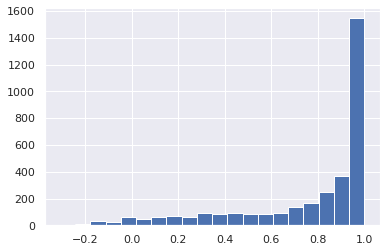

In [340]:
from os import replace
# removing irrelevant columns from data (Taste-exteroception feature has only 0 (No) values, which will cause problems with similarity calculations)
sim_data = df.drop(columns=['Qhat','Cohens_D','Taste_Exteroception','Study','Neural_Target'],axis=1).reset_index(drop=True)

sim_data = sim_data.fillna(0)
sim_data = sim_data.astype(int)

msq_features = list(sim_data)[3::]

# calculate correlation matrix between features
corr_matrix = sim_data[msq_features].corr()

# convert data to numpy arrays
sim_data_matrix = sim_data.to_numpy()
corr_matrix = corr_matrix.to_numpy()


# create a new dataframe for exploration measures
exploration = pd.DataFrame({'sub_num': [],
                            'session_num': [],
                            'strategy_n': [],
                            'strategy_n+1': [],
                            'soft_cos_similarity': []})

# fill rows with all adjacent strategies
for i in range(len(sim_data)-1):
    y = i+1
    if (sim_data.loc[i, 'sub_num'] == sim_data.loc[y, 'sub_num']) & (sim_data.loc[i, 'session_num'] == sim_data.loc[y, 'session_num']) & (sim_data.loc[i, 'cycle_num'] < sim_data.loc[y, 'cycle_num']):
        exploration.loc[i, 'sub_num'] = sim_data.loc[i, 'sub_num']
        exploration.loc[i, 'session_num'] = sim_data.loc[i, 'session_num']
        exploration.loc[i, 'strategy_n'] = sim_data.loc[i, 'cycle_num']
        exploration.loc[i, 'strategy_n+1'] = sim_data.loc[y,'cycle_num']


# calculate soft cosine for each pair of cycles in data_matrix
soft_cosine_lst = []
for t in range(len(sim_data_matrix)-1):
    cur_soft_cos = soft_cos_calc(sim_data_matrix[t, 3::], sim_data_matrix[t+1, 3::], corr_matrix)
    soft_cosine_lst.append(cur_soft_cos)

soft_cosine_lst.append(0)
soft_cosine_lst =  [0 if math.isnan(x) else x for x in soft_cosine_lst]

# add soft cos calculation to sim_data df
sim_data['soft_cos_similarity'] = soft_cosine_lst

# extract the relevant rows for exploration (excuding pairs of different subjects or sessions)
valid_pairs = sim_data

for i in range(len(valid_pairs)-1):
    y= i+1
    if not ((valid_pairs.loc[i, 'sub_num'] == valid_pairs.loc[y, 'sub_num']) & (valid_pairs.loc[i, 'session_num'] == valid_pairs.loc[y, 'session_num']) & (valid_pairs.loc[i, 'cycle_num'] < valid_pairs.loc[y, 'cycle_num'])):
        valid_pairs.drop(index = i, inplace= True)
valid_pairs = valid_pairs.iloc[:-1 , :]

# copy soft_cos to exploration df
exploration['soft_cos_similarity'] = valid_pairs['soft_cos_similarity']
#save exploration to excel
# let's plot similarity across adjacent strategies across all subjects:
fig=plt.hist(exploration['soft_cos_similarity'], bins = 20) 


In [341]:
sim_data.head()

,sub_num,session_num,cycle_num,Vision_Exteroception,Auditory_Exteroception,Smell_Exteroception,Tactile_Exteroception,Pulse,Viceral_sensations,Breathing,...,Tension,Other_Emotion,Pleasure,Suffering,Approach,Avoidance,Expectation,Impulse,Other_Motivation,soft_cos_similarity
0,11,1,6,1,1,0,0,0,0,0,...,1,0,0,0,0,1,1,0,0,0.819610
1,11,1,7,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0.901241
3,11,2,6,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0.782830
4,11,2,7,1,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1.000000
6,11,3,6,1,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0.663508


We can see that many adjacent strategies are actually a repeated strategy ( soft_cos = 1), but that there are many other instances of changing the strategy to various degrees (soft_cas < 1).

Now let's plot the time course of two representative subjects with differing exploration trajectories:

- A subject that zig-zags between strategies:

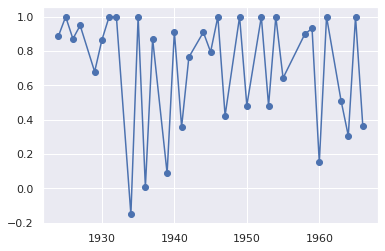

In [342]:
zigzag_sub = exploration[exploration['sub_num']==12]    
plt.plot(zigzag_sub.index,zigzag_sub['soft_cos_similarity'],'-o')

- Another subject that continueously explores their mental space (see that the values are lower):

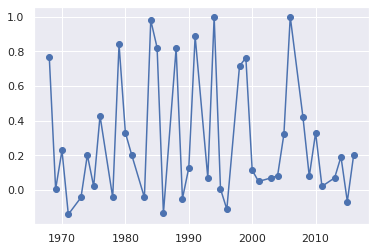

In [343]:
uncertain_sub = exploration[exploration['sub_num']==13]    
plt.plot(uncertain_sub.index,uncertain_sub['soft_cos_similarity'],'-o')

- A subject that rarely explores their mental space:

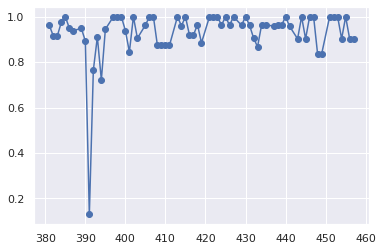

In [344]:
rigid_sub = exploration[exploration['sub_num']==2872]    
plt.plot(rigid_sub.index,rigid_sub['soft_cos_similarity'],'-o')

- And finally, a subject that gradually converges on a specific strategy/mental space:

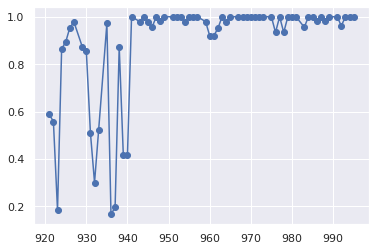

In [345]:
converging_sub = exploration[exploration['sub_num']==5862]    
plt.plot(converging_sub.index,converging_sub['soft_cos_similarity'],'-o')

These cherry-picked types of exploration trajectories illustrate how subjects' exploration differ qualitatively.
Importantly, these estimations can be used for various quantitative analyses:
1. Characterizing these exploration trajectories in a data-driven manner, using pattern analysis methods that suit logitudinal data. 
2. Averaging values per subject to use as individual NF exploration measures, e.g. correlating them with other treatment outcomes. 
3. Assessing the link between levels of exploration and regulation success along practice. This latter option is exhibited in Poster number ***W26***!
